In [1]:
import numpy as np
import scipy
import torch
from matplotlib import pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
import control
from control import matlab
from matplotlib import cm
from matplotlib import transforms as tr

np.random.seed(0)
dev = "cpu"  
device = torch.device(dev) 

In [2]:
sysA = np.array([[0.9871,-0.0056,-0.0037,-0.0015],[0.0099,1.0000,-0.00,-0.00],[0.00,0.0025,1.0,0.0],[0.00,0.00,0.0012,1.00]])
#sysA = 0.99
sysB = np.array([[0.0397],[0.0002],[0.0],[0.0]])
sysC = np.array([0,0.25,0.8,1.2])
sysD = 0
print(np.linalg.eig(sysA))
kp = 20.0
ki = 8.0
kd = 10.0
Tf = 0.01

(array([0.99401227, 0.99647552, 0.99743533, 0.99917689]), array([[-0.48625422,  0.27399793,  0.17365955, -0.01522059],
       [ 0.80396299, -0.76963891, -0.67035056,  0.18306646],
       [-0.33567078,  0.54592321,  0.65344659, -0.55602072],
       [ 0.06727168, -0.18587344, -0.30574506,  0.81061456]]))


In [3]:
T = 1500
np.random.seed(0)
refs = np.zeros((30,T))

randval = 0

for i in range(20):
  refs[i,0:300] = 0
  randval = 8.0*np.random.rand()-4.0
  refs[i,300:900] = randval
  randval = 8.0*np.random.rand()-4.0
  refs[i,900:1500] = randval

for i in range(20,30):
  refs[i,0:250] = 0
  randval = 8.0*np.random.rand()-4.0
  refs[i,250:950] = randval
  randval = 8.0*np.random.rand()-4.0
  refs[i,950:1500] = randval

In [6]:
ref = refs[8,:]
ysat = np.zeros((T,))
uvalssat = np.zeros((T,))
xcont = 0
u = 0
D = 0
ad = Tf/(Tf+0.01)
bd = kd/(Tf+0.01)
noise = 0.01*np.random.randn(T,1)

x0 = np.zeros((4,1))
x = x0
for i in range(T):
   ysat[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+(ref[i]-ysat[i])
   if(i>0):
     D = ad*D-bd*(ysat[i]-ysat[i-1])  
     u = 0.01*ki*xcont+kp*(ref[i]-ysat[i])+D
   if(u>4):
     u=4
   elif(u<-4):
     u=-4
   uvalssat[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);

ynosat = np.zeros((T,))
uvalsnosat = np.zeros((T,))
xcont = 0;
u = 0;
x = x0
D = 0

for i in range(T):
   ynosat[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+(ref[i]-ynosat[i])
   if(i>0):
     D = ad*D-bd*(ynosat[i]-ynosat[i-1])  
     u = 0.01*ki*xcont+kp*(ref[i]-ynosat[i])+D 
   uvalsnosat[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);

ybackc = np.zeros((T,))
uvalsbackc = np.zeros((T,))
xcont = 0
u = 0
ucmd = 0
D = 0
ad = Tf/(Tf+0.01)
bd = kd/(Tf+0.01)
back = 0.2

x = x0
for i in range(T):
   ybackc[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+ki*(ref[i]-ybackc[i])+back*(u-ucmd)
   if(i>0):
     D = ad*D-bd*(ybackc[i]-ybackc[i-1])  
     ucmd = 0.01*xcont+kp*(ref[i]-ybackc[i])+D
   if(ucmd>4):
     u=4
   elif(ucmd<-4):
     u=-4
   else:
     u = ucmd
   uvalsbackc[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);        

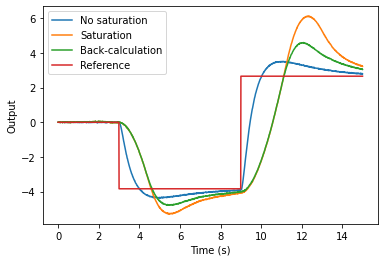

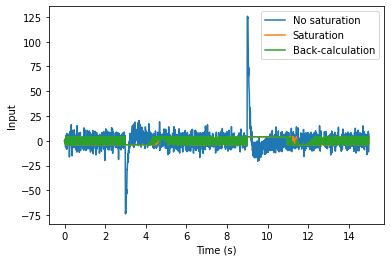

In [7]:
plt.figure
plt.plot(0.01*np.arange(T),ynosat)
plt.plot(0.01*np.arange(T),ysat)
plt.plot(0.01*np.arange(T),ybackc)
plt.plot(0.01*np.arange(T),ref)
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend(["No saturation","Saturation","Back-calculation","Reference"])
plt.show()

plt.figure
plt.plot(0.01*np.arange(T),uvalsnosat)
plt.plot(0.01*np.arange(T),uvalssat)
plt.plot(0.01*np.arange(T),uvalsbackc)
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.legend(["No saturation","Saturation","Back-calculation"])
plt.show()

In [ ]:
# Robust Optimization
systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)


advA = torch.randn(4,4,requires_grad=True)
advB = torch.randn(4,1,requires_grad=True)

kpst = torch.tensor(kp,requires_grad=True)
kist = torch.tensor(ki,requires_grad=True)
kdst = torch.tensor(kd,requires_grad=True)
Tft = torch.tensor(Tf,requires_grad=True)
backst = torch.tensor(back,requires_grad=True)
optimizer = torch.optim.Adam((kpst,kist,kdst,backst), lr=0.1)
optimadv = torch.optim.Adam((advA,advB), lr=0.01)
#Tfoptimizer = torch.optim.Adam([Tft],lr=0.0001)
advpower = 0.01
averagecost = 0
strengthenadversary = False
nc = 0
na = 0
for episodes in range(2001):
  #kpt = F.relu(kpt)
  #kit = F.relu(kit)
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
  ref = refs[episodeorder[cepisode],:]  
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  advcost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kdt,(Tft+0.01))
  noise = 0.05*torch.randn(1000,1)  
  for t in range(1000):
    yold = yt
    yt = torch.clamp(torch.matmul(systC.float(),x)+noise[t],-10.0,10.0)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    xcont = xcont+kit*(reft[t]-yt)
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       u = satt*torch.tanh((0.1*kit*xcont+kpt*(reft[t]-yt)+D)/satt)
    u = torch.clamp(u,-4.0,4.0)
    adv = torch.matmul(advA.float(),x)+advB.float()*u
    x = torch.matmul(systA.float(),x)+systB.float()*u+torch.clamp(adv,-1*advpower,advpower)
    cost = cost+(reft[t]-yt)**2
    advcost = advcost-yt**2
  averagecost = averagecost+cost  
  if(episodes%200==0):
    #print(kpt,kdt,kit,Tft)
    print(episodes,cost,advcost)
    if(episodes==0):
       prevcost = cost
    if(episodes!=0):
      if(not strengthenadversary and cost<prevcost):
        prevcost = cost
        print("Controller progress")  
        #advpower = advpower*2
        print(kpst,kist,kdst,backst)
        strengthenadversary = True
        nc = nc+1
      elif(strengthenadversary and advcost<prevadvcost):
        print("Adversary progress")  
        #advpower = advpower/2
        prevadvcost = advcost
        #kpt = torch.tensor(1.5*kpt*torch.rand(1)+0.5*kpt,requires_grad=True)
        #kit = torch.tensor(1.5*kit*torch.rand(1)+0.5*kit,requires_grad=True)
        #kdt = torch.tensor(1.5*kdt*torch.rand(1)+0.5*kdt,requires_grad=True)
        #satt = torch.tensor(1.5*satt*torch.rand(1)+0.5*satt,requires_grad=True)
        optimizer = torch.optim.Adam((kpt,kit,kdt,satt), lr=0.1)
        strengthenadversary = False
        na = na+1
      elif(strengthenadversary):
        print("Controller won, increasing adversary power")
        advpower = advpower*2;
    prevcost = cost
    prevadvcost = advcost
  if not strengthenadversary:      
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
  else:
    optimadv.zero_grad()
    advcost.backward()
    optimadv.step()

In [36]:
class neuralPID(torch.nn.Module):
   def __init__(self):
    super(neuralPID, self).__init__()
    torch.manual_seed(2)
    self.kplayer1 = torch.nn.Linear(2,2)
    self.kplayer2 = torch.nn.Linear(2,1)
    self.kilayer1 = torch.nn.Linear(2,2)
    self.kilayer2 = torch.nn.Linear(2,1)
    self.kdlayer1 = torch.nn.Linear(2,2)
    self.kdlayer2 = torch.nn.Linear(2,1)
    self.backlayer1 = torch.nn.Linear(2,2)
    self.backlayer2 = torch.nn.Linear(2,1)
  
   def forward(self,x):
    sigmoid = torch.nn.Tanh()
    kp = self.kplayer2(sigmoid(self.kplayer1(x)))
    ki = self.kilayer2(sigmoid(self.kilayer1(x)))
    kd = self.kdlayer2(sigmoid(self.kdlayer1(x)))
    back = self.backlayer2(sigmoid(self.backlayer1(x)))
    #kd = torch.clamp(kd,0,400)
    #kp = torch.clamp(kp,0,400)
    #ki = torch.clamp(ki,0,400)
    return kp,ki,kd,back

In [37]:
Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

In [38]:
costinit = np.zeros((30,))
costinitback = np.zeros((30,))

yinit = np.zeros((30,T))
uinit = np.zeros((30,T))
yinitback = np.zeros((30,T))
uinitback = np.zeros((30,T))
Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

for iters in range(0,30):
  ref = refs[iters,:]
  reft = torch.tensor(ref)
  noise = 0.01*torch.randn(T,1)

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinit[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+err
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       u = (0.01*kiit*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(u,-3.0,3.0)
    uinit[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinit[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinitback[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+kiit*err+backit*(u-ucmd)
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(ucmd,-3.0,3.0)
    uinitback[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinitback[iters] = cost.detach().numpy()

[  158.64006042   307.55944824  1609.31750488  1641.27770996
 10468.11816406  9691.12792969   488.83981323  1977.68835449
  5730.42480469  3097.52514648  3123.77050781  6380.66064453
   712.59301758   829.53283691  8099.89746094  1762.5279541
   343.81796265 13691.99414062  2498.64233398   782.48931885
  3436.1237793    991.18817139 12464.2265625  14776.09375
  2983.02319336  2130.05517578   528.66064453  5086.16552734
   960.20562744  3931.68994141]


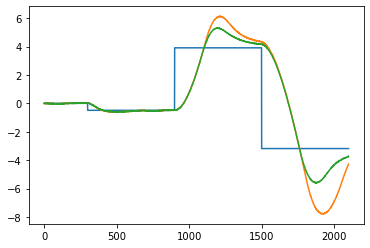

In [39]:
print(costinit)
plt.figure()
plt.plot(refs[17,:])
plt.plot(yinit[17,:])
plt.plot(yinitback[17,:])

In [40]:
# Initialize network
Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

kpt = torch.tensor(kp,requires_grad=True)
kit = torch.tensor(ki,requires_grad=True)
kdt = torch.tensor(kd,requires_grad=True)
backt = torch.tensor(back,requires_grad=True)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

PIDparams = neuralPID()
#optimizer = torch.optim.Adam((PIDparams.parameters()), lr=0.1)
#for iters in range(1000):
#   kpt,kit,kdt = PIDparams(torch.randn(3,))
#   print(kpt,kit,kdt)
#   loss = (kpt-kpit)**2+(kit-kiit)**2+(kdt-kdit)**2
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()    
   #print(iters,loss) 

In [41]:
ysat = np.zeros((T,))
uvalssat = np.zeros((T,))

optimizer = torch.optim.Adam((PIDparams.parameters()), lr=0.1, weight_decay=0.1)

smooth = 0.9
closs = 0
dtlossvals = []

for episodes in range(501):
  #cepisode = np.random.randint(20)  
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
  ref = refs[episodeorder[cepisode],:]
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  ad = torch.div(Tft,(Tft+0.01))
  noise = 0.01*torch.randn(T,1)
  kpt = kpt.clone().detach()
  kit = kit.clone().detach()
  kdt = kdt.clone().detach()
  backt = backt.clone().detach()

  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t]
    saterr = u-ucmd
    err = reft[t]-yt
    ninput = torch.cat((err.detach(),saterr.detach()),0)
    kpdt,kidt,kddt,backdt = PIDparams(ninput)
    kpt = smooth*kpt+(1-smooth)*(kpit+kpdt)
    kit = smooth*kit+(1-smooth)*(kiit+kidt)
    kdt = smooth*kdt+(1-smooth)*(kdit+kddt)
    backt = smooth*backt+(1-smooth)*(backit+backdt)
    xcont = xcont+kit*err+backt*saterr.detach()
    if(t>0):
      bd = torch.div(kdt,(Tft+0.01))
      D = ad*D-bd*(yt-yold);  
      ucmd = (0.01*xcont+kpt*(reft[t]-yt)+D)
      u = torch.clamp(ucmd,-3.0,3.0)
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  closs = closs+cost   
  if(episodes%120<20):
    print(episodes,cost)
    
  if(episodes%20==19):    
    dtlossvals.append(closs.clone().detach().numpy()[0]/20)
    closs = 0  
    
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

                                     

0 tensor([2823.3674], grad_fn=<AddBackward0>)
1 tensor([1546.0986], grad_fn=<AddBackward0>)
2 tensor([6196.3403], grad_fn=<AddBackward0>)
3 tensor([9909.3770], grad_fn=<AddBackward0>)
4 tensor([298.1891], grad_fn=<AddBackward0>)
5 tensor([1496.3936], grad_fn=<AddBackward0>)
6 tensor([341.1779], grad_fn=<AddBackward0>)
7 tensor([3692.6951], grad_fn=<AddBackward0>)
8 tensor([2743.5444], grad_fn=<AddBackward0>)
9 tensor([634.0900], grad_fn=<AddBackward0>)
10 tensor([5777.2363], grad_fn=<AddBackward0>)
11 tensor([153.1761], grad_fn=<AddBackward0>)
12 tensor([674.0117], grad_fn=<AddBackward0>)
13 tensor([4036.1621], grad_fn=<AddBackward0>)
14 tensor([1538.7029], grad_fn=<AddBackward0>)
15 tensor([1256.0808], grad_fn=<AddBackward0>)
16 tensor([6779.1699], grad_fn=<AddBackward0>)
17 tensor([6154.4404], grad_fn=<AddBackward0>)
18 tensor([407.6245], grad_fn=<AddBackward0>)
19 tensor([643.3539], grad_fn=<AddBackward0>)
120 tensor([6691.0283], grad_fn=<AddBackward0>)
121 tensor([2277.0740], grad_

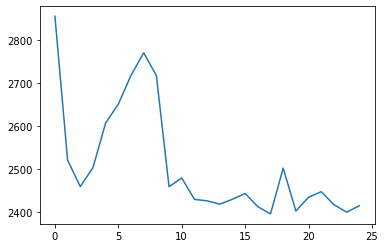

In [42]:
plt.figure()
plt.plot(dtlossvals)
torch.save(PIDparams.state_dict(), "./datafiles/4odswgradientparams")

In [43]:
kpst = torch.tensor(kp,requires_grad=True)
kist = torch.tensor(ki,requires_grad=True)
kdst = torch.tensor(kd,requires_grad=True)
backst = torch.tensor(back,requires_grad=True)
Tft = torch.tensor(Tf,requires_grad=True)
optimizer = torch.optim.Adam((kpst,kist,kdst,backst), lr=0.08, weight_decay=0.5)

stlossvals = []
closs = 0
kptrain = []
kitrain = []
kdtrain = []
backtrain = []
for episodes in range(501):
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
  ref = refs[episodeorder[cepisode],:]
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  ucmd = torch.tensor([0.0],requires_grad=True)
  u = torch.tensor([0.0],requires_grad=True)  
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kdst,(Tft+0.01))
  noise = 0.01*torch.randn(T,1)
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kist*(reft[t]-yt)+backst*saterr
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpst*(reft[t]-yt)+D)
    u = torch.clamp(ucmd,-3.0,3.0)
    uvalssat[i] = u;
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+torch.clamp((reft[t]-yt)**2,0,50)
  closs = closs+cost  
  if(episodes%20==19):    
    stlossvals.append(closs.clone().detach().numpy()/20)
    closs = 0
  kptrain.append(kpst.clone().detach().numpy())
  kitrain.append(kist.clone().detach().numpy())
  kdtrain.append(kdst.clone().detach().numpy())
  backtrain.append(backst.clone().detach().numpy())  
  if(episodes%120<20):
    #print(kpt,kdt,kit,Tft)
    print(episodes,cost,backst) 
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

print(kpst,kist,kdst,backst)

0 tensor([1505.8057], grad_fn=<AddBackward0>) tensor(0.2000, requires_grad=True)
1 tensor([335.2750], grad_fn=<AddBackward0>) tensor(0.2800, requires_grad=True)
2 tensor([4809.9082], grad_fn=<AddBackward0>) tensor(0.3387, requires_grad=True)
3 tensor([708.6162], grad_fn=<AddBackward0>) tensor(0.4033, requires_grad=True)
4 tensor([2456.5691], grad_fn=<AddBackward0>) tensor(0.4596, requires_grad=True)
5 tensor([1350.0309], grad_fn=<AddBackward0>) tensor(0.5168, requires_grad=True)
6 tensor([4033.8718], grad_fn=<AddBackward0>) tensor(0.5692, requires_grad=True)
7 tensor([6664.2363], grad_fn=<AddBackward0>) tensor(0.6243, requires_grad=True)
8 tensor([6134.7461], grad_fn=<AddBackward0>) tensor(0.6752, requires_grad=True)
9 tensor([668.3636], grad_fn=<AddBackward0>) tensor(0.7154, requires_grad=True)
10 tensor([1533.0461], grad_fn=<AddBackward0>) tensor(0.7516, requires_grad=True)
11 tensor([5337.0630], grad_fn=<AddBackward0>) tensor(0.7848, requires_grad=True)
12 tensor([1981.1030], grad_f

tensor(9.7202, requires_grad=True) tensor(-0.4555, requires_grad=True) tensor(2.2555, requires_grad=True) tensor(0.2053, requires_grad=True)


In [14]:
kpdft = torch.tensor(kp,requires_grad=True)
kidft = torch.tensor(ki,requires_grad=True)
kddft = torch.tensor(kd,requires_grad=True)

#backdft = torch.tensor(0.1,requires_grad=True)

backdft = torch.zeros(500,requires_grad=True)

optimizer = torch.optim.Adam([backdft], lr=0.1, weight_decay=0.1)

dftlossvals = []
closs = 0
for episodes in range(501):
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
    
  ref = refs[episodeorder[cepisode],:]
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  ucmd = torch.tensor([0.0],requires_grad=True)   
  u = torch.tensor([0.0],requires_grad=True)  
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kddft,(Tft+0.01))

  noise = 0.01*torch.randn(T,1)
  satest = torch.zeros(500,requires_grad=False)
  #satestsum = torch.sum(satest)
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    #satestc = satest.clone().detach()
    #satest[1:500] = satestc[0:499] 
    satest = torch.roll(satest,1)
    satest[0] = u-ucmd
    #print(satest)
    #satestsum = satestsum+satest[0]
    xcont = xcont+kidft*(reft[t]-yt)
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpdft*(reft[t]-yt)+D+0.01*torch.dot(backdft,satest.detach()))
    u = torch.clamp(ucmd,-1.0,1.0)
    x = torch.matmul(systA.float(),x)+systB.float()*u
    #u2 = u1
    #u1 = u
    cost = cost+torch.clamp((reft[t]-yt)**2,0,50)
  closs = closs+cost  
  if(episodes%20==19):    
    dftlossvals.append(closs.clone().detach().numpy()[0]/20)
    closs = 0 
  if(episodes%120<20):
    print(episodes,cost)
    
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

0 tensor([116.2484], grad_fn=<AddBackward0>)
1 tensor([897.6294], grad_fn=<AddBackward0>)
2 tensor([1824.0211], grad_fn=<AddBackward0>)
3 tensor([104.2209], grad_fn=<AddBackward0>)
4 tensor([147.7334], grad_fn=<AddBackward0>)
5 tensor([106.9844], grad_fn=<AddBackward0>)
6 tensor([3739.4043], grad_fn=<AddBackward0>)
7 tensor([100.3412], grad_fn=<AddBackward0>)
8 tensor([2665.2815], grad_fn=<AddBackward0>)
9 tensor([2011.6920], grad_fn=<AddBackward0>)
10 tensor([393.4470], grad_fn=<AddBackward0>)
11 tensor([3148.3555], grad_fn=<AddBackward0>)
12 tensor([102.5034], grad_fn=<AddBackward0>)
13 tensor([908.8975], grad_fn=<AddBackward0>)
14 tensor([109.7121], grad_fn=<AddBackward0>)
15 tensor([105.0202], grad_fn=<AddBackward0>)
16 tensor([113.0611], grad_fn=<AddBackward0>)
17 tensor([1340.2224], grad_fn=<AddBackward0>)
18 tensor([2626.2021], grad_fn=<AddBackward0>)
19 tensor([2394.5020], grad_fn=<AddBackward0>)
120 tensor([101.9798], grad_fn=<AddBackward0>)
121 tensor([2396.6541], grad_fn=<Ad

9.720245 -0.45552662 2.2555344 0.2053037


Text(0, 0.5, 'Back-calculation constant')

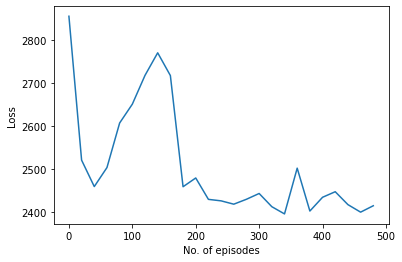

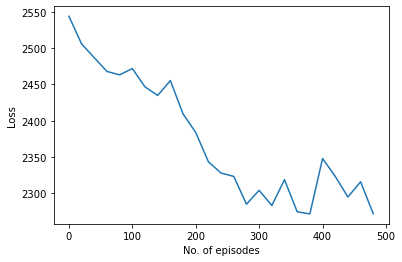

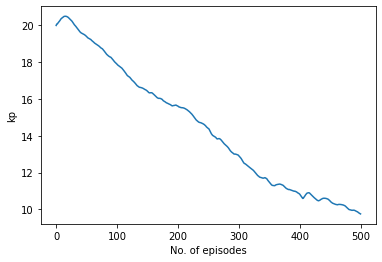

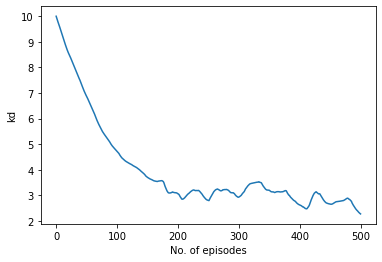

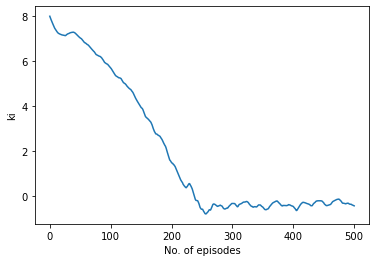

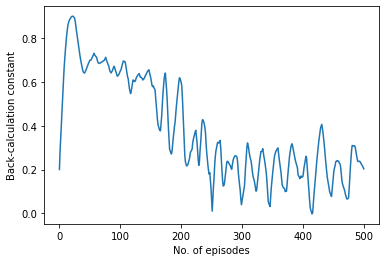

In [45]:
kps = kpst.detach().numpy()
kis = kist.detach().numpy()
kds = kdst.detach().numpy()
backs = backst.detach().numpy()
print(kps,kis,kds,backs)

plt.figure()
plt.plot(np.arange(len(dtlossvals))*20,dtlossvals)
plt.xlabel("No. of episodes")
plt.ylabel("Loss")

#plt.figure()
#plt.plot(np.arange(len(dftlossvals))*20,dftlossvals)
#plt.xlabel("No. of episodes")
#plt.ylabel("Loss")

plt.figure()
plt.plot(np.arange(len(stlossvals))*20,stlossvals)
plt.xlabel("No. of episodes")
plt.ylabel("Loss")

plt.figure()
plt.plot(np.arange(len(kptrain)),kptrain)
plt.xlabel("No. of episodes")
plt.ylabel("kp")

plt.figure()
plt.plot(np.arange(len(kdtrain)),kdtrain)
plt.xlabel("No. of episodes")
plt.ylabel("kd")

plt.figure()
plt.plot(np.arange(len(kitrain)),kitrain)
plt.xlabel("No. of episodes")
plt.ylabel("ki")

plt.figure()
plt.plot(np.arange(len(backtrain)),backtrain)
plt.xlabel("No. of episodes")
plt.ylabel("Back-calculation constant")

In [46]:
costdgradient = np.zeros((30,))
costinit = np.zeros((30,))
costsgradient = np.zeros((30,))
costinitback = np.zeros((30,))
#costdfgradient = np.zeros((30,))

ydgradient = np.zeros((30,T))
udgradient = np.zeros((30,T))

ysgradient = np.zeros((30,T))
usgradient = np.zeros((30,T))

#ydfgradient = np.zeros((10,T))
#udfgradient = np.zeros((10,T))

kpdgradient = np.zeros((30,T))
kidgradient = np.zeros((30,T))
kddgradient = np.zeros((30,T))
backdgradient = np.zeros((30,T))
#PIDparams = neuralPID()
#PIDparams.load_state_dict(torch.load("dgradientparams"))

yinit = np.zeros((30,T))
uinit = np.zeros((30,T))
yinitback = np.zeros((30,T))
uinitback = np.zeros((30,T))
smooth = 0.9

for iters in range(0,30):
  ref = refs[iters,:]
  reft = torch.tensor(ref)
  noise = 0.01*torch.randn(T,1)  
  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    ydgradient[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    err = reft[t]-yt
    ninput = torch.cat((err.detach(),saterr.detach()),0)
    kpdt,kidt,kddt,backdt = PIDparams(ninput)
    kpt = smooth*kpt+(1-smooth)*(kpit+kpdt)
    kit = smooth*kit+(1-smooth)*(kiit+kidt)
    kdt = smooth*kdt+(1-smooth)*(kdit+kddt)
    backt = smooth*backt+(1-smooth)*(backit+backdt)
    xcont = xcont+kit*err+backt*saterr.detach()
    if(t>0):
      bd = torch.div(kdt,(Tft+0.01))
      D = ad*D-bd*(yt-yold);  
      ucmd = (0.01*xcont+kpt*(reft[t]-yt)+D)
      u = torch.clamp(ucmd,-3.0,3.0)
      udgradient[iters,t] = u.clone().detach().numpy()
      kpdgradient[iters,t] = kpt.clone().detach().numpy()
      kidgradient[iters,t] = kit.clone().detach().numpy()
      kddgradient[iters,t] = kdt.clone().detach().numpy()
      backdgradient[iters,t] = backt.clone().detach().numpy()  
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
    
  costdgradient[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinit[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+err
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       u = (0.01*kiit*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(u,-3.0,3.0)
    uinit[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinit[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kdit,(Tft+0.01))

  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinitback[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kiit*(reft[t]-yt)+backit*saterr.detach()
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpit*(reft[t]-yt)+D)
    u = torch.clamp(ucmd,-3.0,3.0)
    usgradient[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinitback[iters] = cost.detach().numpy() 

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  bd = torch.div(kdst,(Tft+0.01))

  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    ysgradient[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kist*(reft[t]-yt)+backst*saterr.detach()
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpst*(reft[t]-yt)+D)
    u = torch.clamp(ucmd,-3.0,3.0)
    usgradient[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costsgradient[iters] = cost.detach().numpy() 

  #xcont = torch.tensor([0.0],requires_grad=True)
  #x = torch.tensor([[0.0],[0.0],[0.0],[0.0]],requires_grad=True)  
  #u = torch.tensor([0.0],requires_grad=True)
  #u2 = torch.tensor([0.0],requires_grad=True)
  #u1 = torch.tensor([0.0],requires_grad=True)     
  #cost = torch.tensor([0.0],requires_grad=True)
  #yt = torch.tensor([0.0],requires_grad=True)
  #D  = torch.tensor([0.0],requires_grad=False)
  #satest = torch.zeros(500,requires_grad=False)
  #ad = torch.div(Tft,(Tft+0.01))
  #bd = torch.div(kddft,(Tft+0.01))
    
  #for t in range(T):
  #  yold = yt
  #  yt = torch.matmul(systC.float(),x)+noise[t]
  #  ydfgradient[iters,t] = yt.clone().detach().numpy()
  #  satest = torch.roll(satest,1)
  #  satest[0] = u-ucmd
  #  xcont = xcont+kidft*(reft[t]-yt)
  #  if(t>0):
  #     D = ad*D-bd*(yt-yold);  
  #     ucmd = (0.01*xcont+kpdft*(reft[t]-yt)+D+0.01*torch.dot(backdft,satest.detach()))
  #  u = torch.clamp(ucmd,-1.0,1.0)
  #  x = torch.matmul(systA.float(),x)+systB.float()*u
  #  cost = cost+torch.clamp((reft[t]-yt)**2,0,50)
  #costdfgradient[iters] = cost.detach().numpy()

In [47]:
print("Dgradient-dynamic",costdgradient)
print("Dgradient-static",costsgradient)
print("Initial",costinit)
print("Initial-backcalculation",costinitback)

print("Dgradient-dynamic",np.mean(costdgradient[0:20]),np.std(costdgradient[0:20]))
print("Dgradient-static",np.mean(costsgradient[0:20]),np.std(costsgradient[0:20]))
print("Initial",np.mean(costinit[0:20]),np.std(costinit[0:20]))
print("Initial-backcalculation",np.mean(costinitback[0:20]),np.std(costinitback[0:20]))

print("Dgradient-dynamic",np.mean(costdgradient[20:30]),np.std(costdgradient[20:30]))
print("Dgradient-static",np.mean(costsgradient[20:30]),np.std(costsgradient[20:30]))
print("Initial",np.mean(costinit[20:30]),np.std(costinit[20:30]))
print("Initial-backcalculation",np.mean(costinitback[20:30]),np.std(costinitback[20:30]))

Dgradient-dynamic [ 177.30361938  288.41973877 1675.35266113 1303.36364746 5911.53417969
 6542.56542969  720.33966064 1542.42077637 3467.79760742 1982.2767334
 2290.11743164 4175.72070312  784.49676514  579.07397461 5083.82324219
 1256.74414062  323.48049927 7300.60253906 2003.62194824  597.98425293
 2701.48730469  810.21643066 7846.88330078 8226.37207031 2139.66333008
 1527.67565918  467.04217529 3540.98876953  730.81842041 3734.23193359]
Dgradient-static [ 149.00984192  238.62916565 1861.42956543 1232.35498047 5948.84619141
 5143.26855469  871.67004395 1457.92224121 3503.37670898 1969.77685547
 2017.58813477 3579.57714844  723.09790039  612.28137207 4430.54101562
 1688.51293945  281.29928589 6729.76269531 1617.95031738  733.20672607
 2152.34545898 1282.37158203 6598.79199219 7259.18408203 2497.77929688
 2637.97851562  537.5569458  2868.11230469  665.47003174 2676.41894531]
Initial [  168.36767578   306.08877563  1639.43493652  1721.43212891
 10473.66503906  9511.26464844   504.231903

Text(0, 0.5, 'Back-calculation gain')

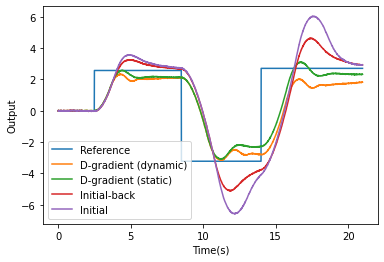

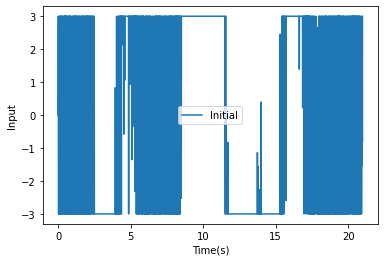

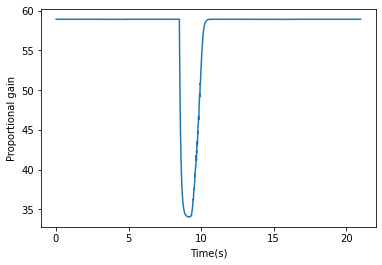

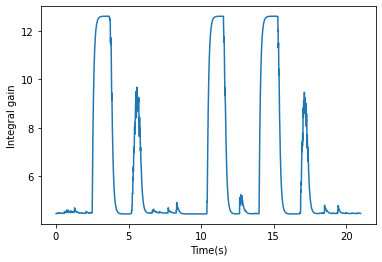

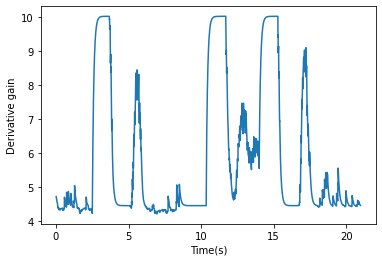

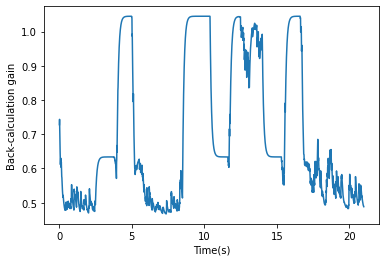

In [48]:
plt.figure()
plt.plot(0.01*np.arange(0,T),refs[22,:])
plt.plot(0.01*np.arange(0,T),ydgradient[22,:])
plt.plot(0.01*np.arange(0,T),ysgradient[22,:])
plt.plot(0.01*np.arange(0,T),yinitback[22,:])
plt.plot(0.01*np.arange(0,T),yinit[22,:])
plt.xlabel("Time(s)")
plt.ylabel("Output")
plt.legend(["Reference","D-gradient (dynamic)","D-gradient (static)","Initial-back","Initial"])

plt.figure()
plt.plot(0.01*np.arange(0,T),uinit[23,:])
#plt.plot(0.01*np.arange(0,T),udgradient[20,:])
#plt.plot(0.01*np.arange(0,T),usgradient[20,:])
#plt.plot(0.01*np.arange(0,T),uinitback[20,:])
plt.xlabel("Time(s)")
plt.ylabel("Input")
plt.legend(["Initial","D-gradient (dynamic)","D-gradient (static)","Initial-back"])

plt.figure()
plt.plot(0.01*np.arange(1,T),kpdgradient[23,1:])
plt.xlabel("Time(s)")
plt.ylabel("Proportional gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),kidgradient[23,1:])
plt.xlabel("Time(s)")
plt.ylabel("Integral gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),kddgradient[23,1:])
plt.xlabel("Time(s)")
plt.ylabel("Derivative gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),backdgradient[23,1:])
plt.xlabel("Time(s)")
plt.ylabel("Back-calculation gain")

In [49]:
# Save everything
np.save("./datafiles/4oddswstabledtlossvals",dtlossvals)
np.save("./datafiles/4oddswstablestlossvals",stlossvals)
#np.save("4odddftlossvals",dftlossvals)
np.save("./datafiles/4oddswstableydgradient",ydgradient)
np.save("./datafiles/4oddswstableyinitback",yinitback)
np.save("./datafiles/4oddswstableysgradient",ysgradient)
np.save("./datafiles/4oddswstableyinit",yinit)
np.save("./datafiles/4oddswstableudgradient",udgradient)
np.save("./datafiles/4oddswstableuinitback",uinitback)
np.save("./datafiles/4oddswstableusgradient",usgradient)
np.save("./datafiles/4oddswstableuinit",uinit)
np.save("./datafiles/4oddswstablekpdgradient",kpdgradient)
np.save("./datafiles/4oddswstablekidgradient",kidgradient)
np.save("./datafiles/4oddswstablekddgradient",kddgradient)
np.save("./datafiles/4oddswstablebackdgradient",backdgradient)
np.save("./datafiles/4oddswstablekptrain",kptrain)
np.save("./datafiles/4oddswstablekitrain",kitrain)
np.save("./datafiles/4oddswstablekdtrain",kdtrain)
np.save("./datafiles/4oddswstablebacktrain",backtrain)
np.save("./datafiles/4oddswstablerefs",refs)
np.save("./datafiles/4oddswstablecostdgradient",costdgradient)
np.save("./datafiles/4oddswstablecostinitback",costinitback)
np.save("./datafiles/4oddswstablecostsgradient",costsgradient)
np.save("./datafiles/4oddswstablecostinit",costinit)

In [50]:
dtlossvals = np.load("./datafiles/4oddswstabledtlossvals.npy")
stlossvals = np.load("./datafiles/4oddswstablestlossvals.npy")
ydgradient = np.load("./datafiles/4oddswstableydgradient.npy")
ysgradient = np.load("./datafiles/4oddswstableysgradient.npy")
yinit = np.load("./datafiles/4oddswstableyinit.npy")
yinitback = np.load("./datafiles/4oddswstableyinitback.npy")
udgradient = np.load("./datafiles/4oddswstableudgradient.npy")
usgradient = np.load("./datafiles/4oddswstableusgradient.npy")
uinit = np.load("./datafiles/4oddswstableuinit.npy")
uinitback = np.load("./datafiles/4oddswstableuinitback.npy")
kpdgradient = np.load("./datafiles/4oddswstablekpdgradient.npy")
kidgradient = np.load("./datafiles/4oddswstablekidgradient.npy")
backdgradient = np.load("./datafiles/4oddswstablebackdgradient.npy")
kptrain = np.load("./datafiles/4oddswstablekptrain.npy")
kitrain = np.load("./datafiles/4oddswstablekitrain.npy")
backtrain = np.load("./datafiles/4oddswstablebacktrain.npy")
refs = np.load("./datafiles/4oddswstablerefs.npy")
costdgradient = np.load("./datafiles/4oddswstablecostdgradient.npy")
costsgradient = np.load("./datafiles/4oddswstablecostsgradient.npy")
costinit = np.load("./datafiles/4oddswstablecostinit.npy")
costinitback = np.load("./datafiles/4oddswstablecostinitback.npy")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


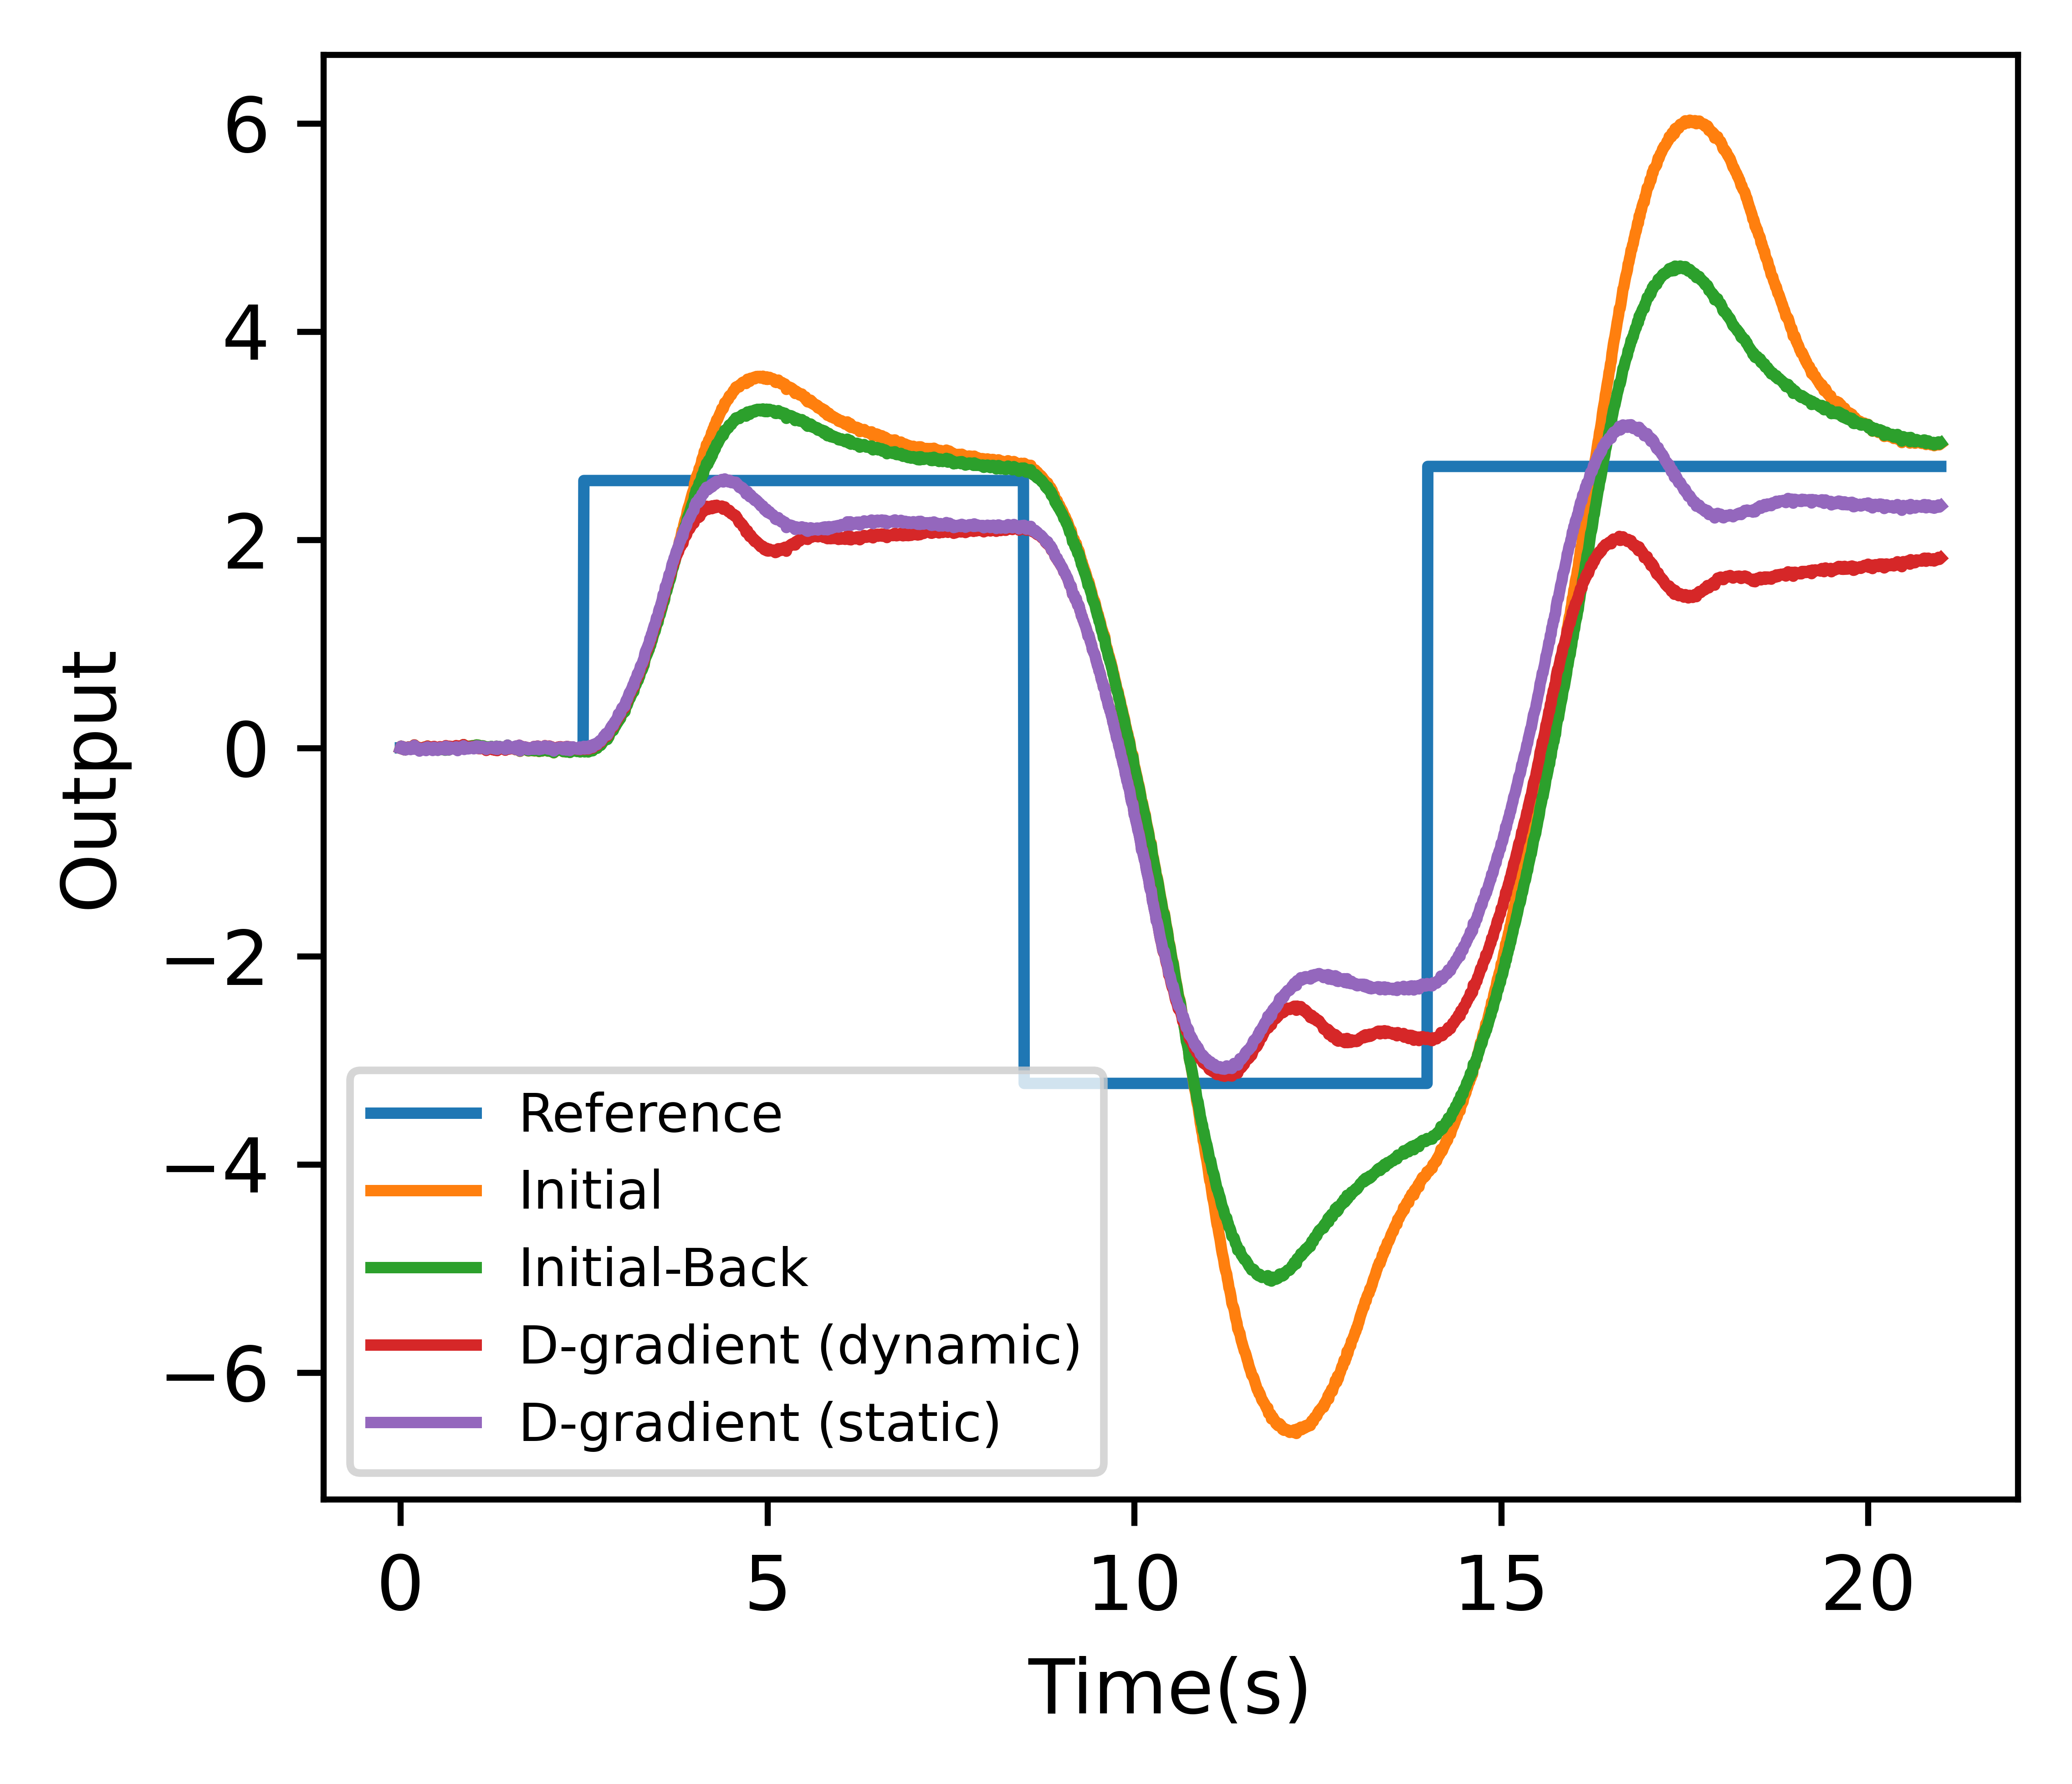

In [51]:
plt.figure(dpi=1200,figsize=[4.0,3.5])
plt.plot(0.01*np.arange(0,T),refs[22,:])
plt.plot(0.01*np.arange(0,T),yinit[22,:])
plt.plot(0.01*np.arange(0,T),yinitback[22,:])
plt.plot(0.01*np.arange(0,T),ydgradient[22,:])
plt.plot(0.01*np.arange(0,T),ysgradient[22,:])
plt.xlabel("Time(s)")
plt.ylabel("Output")
plt.legend(["Reference","Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"],fontsize="x-small")

#plt.subplot(1,2,2)
#plt.plot(0.01*np.arange(0,T),uinit[21,:])
#plt.plot(0.01*np.arange(0,T),uinitback[21,:])
#plt.plot(0.01*np.arange(0,T),udgradient[21,:])
#plt.plot(0.01*np.arange(0,T),usgradient[21,:])
#plt.xlabel("Time(s)")
#plt.ylabel("Input")
#plt.legend(["Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"],fontsize="x-small")
plt.savefig("./figures/4oddswstable1.eps", facecolor='w', dpi=1200, edgecolor='b',orientation='portrait', format="eps", bbox_inches=tr.Bbox([[0,0],[4.0,3.5]]), 
            pad_inches=0.0)
plt.figure(dpi=1200,figsize=[10.5,10.5])
plt.subplot(2,2,1)
plt.plot(0.01*np.arange(1,T),kpdgradient[22,1:])
plt.xlabel("Time(s)")
plt.ylabel("Proportional gain")

plt.subplot(2,2,2)
plt.plot(0.01*np.arange(1,T),kidgradient[22,1:])
plt.xlabel("Time(s)")
plt.ylabel("Integral gain")

plt.subplot(2,2,3)
plt.plot(0.01*np.arange(1,T),kddgradient[22,1:])
plt.xlabel("Time(s)")
plt.ylabel("Derivative gain")

plt.subplot(2,2,4)
plt.plot(0.01*np.arange(1,T),backdgradient[22,1:])
plt.xlabel("Time(s)")
plt.ylabel("Back-calculation gain")
plt.savefig("./figures/4oddswstable2.eps", facecolor='w', dpi=1200, edgecolor='b',orientation='portrait', format="eps", bbox_inches=tr.Bbox([[0,0],[10.5,10.5]]), 
            pad_inches=0.0)

In [20]:
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
#PIDpg = neuralPID()
#optimizer = torch.optim.Adam((PIDpg.parameters()), lr=0.1)
#for iters in range(1000):
#   kpt,kit,kdt = PIDpg(torch.randn(3,))
#   print(kpt,kit,kdt)
#   loss = (kpt-kpit)**2+(kit-kiit)**2+(kdt-kdit)**2
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()  

In [21]:
ysat = np.zeros((T,))
uvalssat = np.zeros((T,))

optimizer = torch.optim.Adam((PIDpg.parameters()), lr=0.1)

nupdates = 100
nepisodes = 120
for updates in range(nupdates):
  cost = np.zeros((nepisodes,T))
  ref = refs[updates%20,:]
  rcostsepisode = np.zeros((nepisodes*T,1))
  totalcost = np.zeros((nepisodes,))
  uvalsepisode = np.zeros((nepisodes*T,1))
  PIDinputsepisode = np.zeros((nepisodes*T,3))
  PIDstatesepisode = np.zeros((nepisodes*T,4))
  for episodes in range(nepisodes):
    xcont = 0
    x =[[0.0],[0.0]]  
    u = 0.0
    ucmd = 0.0
    
    ucmdvals = np.zeros((T,1))
    uvals =  np.zeros((T,1))
    PIDinputs = np.zeros((T,3))
    PIDstates = np.zeros((T,4))
    yt = 0.0
    D  = 0.0
    
    ad = Tf/(Tf+0.01)
    adt = torch.tensor(ad,requires_grad=False)
    adt = adt.float()
    noise = 0.01*np.random.randn(T,1)
    sigma = 0.5
    for t in range(T):
      yold = yt
      yt = np.clip(np.dot(sysC,x)+noise[t],-30.0,30.0)
      err = ref[t]-yt[0]
      xcont = xcont+err
      if(t>0):
         inp = np.array([err,u,ucmd])
         ninput = torch.tensor(inp,requires_grad=False)
         PIDinputs[t,:] = inp   
         kpdt,kidt,kddt = PIDpg(ninput.float())
         kpt = kpit+kpdt
         kit = kiit+kidt
         kdt = kdit+kddt
         kpn = kpt.detach().numpy()
         kin = kit.detach().numpy()
         kdn = kdt.detach().numpy()
         #print(kpn,kin,kdn)   
         bd = kdn[0]/(Tf+0.01)
         PIDstates[t,:] = [err,xcont,D,yt[0]-yold[0]] 
         D = ad*D-bd*(yt[0]-yold[0])
         ucmd = (0.01*kin[0]*xcont+kpn[0]*err+D)
      if(episodes==0):
        u = ucmd
      else:  
        u = ucmd+sigma*np.random.randn()
      uvals[t] = u
      u = np.clip(u,-35.0,35.0)
      x = np.dot(sysA,x)+sysB*u;
      cost[episodes,t] = (ref[t]-yt)**2
    #rcosts = np.flip(np.cumsum(np.flip(cost[episodes,:],[0]),0),[0])
    totalcost[episodes] = np.sum(cost[episodes,:])
    rcosts = np.repeat(totalcost[episodes],T,0)
    #if(episodes==0):
    #  print(updates,episodes,rcosts[0])
    rcostsepisode[episodes*T:(episodes+1)*T,0] = rcosts
    uvalsepisode[episodes*T:(episodes+1)*T,:] = uvals
    PIDinputsepisode[episodes*T:(episodes+1)*T,:] = PIDinputs
    PIDstatesepisode[episodes*T:(episodes+1)*T,:] = PIDstates
  print(updates,episodes,np.min(totalcost))
  PIDinputstorch = torch.tensor(PIDinputsepisode).float()
  PIDstatestorch = torch.tensor(PIDstatesepisode).float()
  uvalstorch = torch.tensor(uvalsepisode).float()
  rcoststorch = torch.tensor(rcostsepisode).float()
  costmean = torch.tensor(np.mean(totalcost)).float()
    
  kptvals,kitvals,kdtvals = PIDpg(PIDinputstorch)
  bdtvals = (kd+kdtvals)/(Tft+0.01)  
  Dvals = adt*PIDstatestorch[:,2]-bdtvals*PIDstatestorch[:,3]  
  ucmdvals = 0.01*torch.mul((ki+kitvals),PIDstatestorch[:,1])+torch.mul((kp+kptvals),PIDstatestorch[:,0])+Dvals
  
  updatecost = torch.mean(torch.mul((uvalstorch-ucmdvals)**2,rcoststorch-costmean))/(2*sigma)
  optimizer.zero_grad()
  updatecost.backward()
  optimizer.step()  

NameError: name 'PIDpg' is not defined